In [52]:

import os
os.environ["JAX_PLATFORMS"] = "cpu"
import jax
from pathlib import Path
import orbax.checkpoint as ocp
import shutil
from loguru import logger


def restore_array(path):
    with jax.default_device(jax.devices("cpu")[0]):
        checkpointer = ocp.PyTreeCheckpointer()
        vals_meta = checkpointer.metadata(path)
        sharding = jax.sharding.SingleDeviceSharding(jax.devices("cpu")[0])
        restore_args = ocp.checkpoint_utils.construct_restore_args(
            vals_meta,
            sharding_tree=jax.tree.map(lambda _: sharding, vals_meta)
        )
        restored_vals = checkpointer.restore(path, restore_args=restore_args)
    return restored_vals
layer = 9

In [ ]:
sae_mid = restore_array(os.path.abspath(f"flux1-saes/sae_double_l{layer}_img/30000/default"))["sae_params"]

In [8]:
import numpy as np
W_dec = np.asarray(sae_mid["W_dec"])

In [1]:
import torch
from diffusers import FluxPipeline
torch.set_grad_enabled(False)
pipe = FluxPipeline.from_pretrained("black-forest-labs/FLUX.1-schnell", torch_dtype=torch.bfloat16, device_map="balanced")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

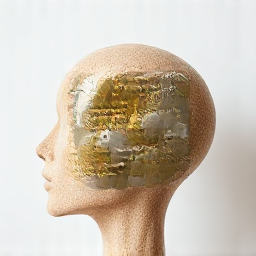

In [ ]:
from collections import OrderedDict
for m in pipe.transformer.modules():
    m._forward_hooks = OrderedDict()
            
height = 256
width = 256
guidance_scale = 3.5
num_inference_steps = 3
# prompts = ["An object on a white background"]
prompts = ["A head made out of a material"]
# prompts = ["A textured pattern"]
def callback_on_step_end(self, i, t, kwargs):
    global timestep
    timestep = i
    return {}
pipe.set_progress_bar_config(disable=True)
def patch_hook(self, input, output):
    image_output = output[1]
    image_output = image_output.unflatten(1, (height // 16, width // 16))
    nrm = 0.9 \
        * image_output.norm(dim=-1, keepdim=True).mean()
    image_output[..., 4:12, 4:12, :] += \
        torch.from_numpy(W_dec[8000]).to(image_output) * nrm
    image_output = image_output.flatten(1, 2)
    return output[:1] + (image_output,) + output[2:]
pipe.transformer.transformer_blocks[layer].register_forward_hook(patch_hook)
with torch.inference_mode():
    image = pipe(
        prompts,
        height=height,
        width=width,
        guidance_scale=guidance_scale,
        num_inference_steps=num_inference_steps,
        max_sequence_length=512,
        generator=torch.Generator("cpu").manual_seed(0),
        return_dict=False,
    )[0][0]
image

TypeError: 'Image' object is not subscriptable

In [9]:
from collections import OrderedDict

with torch.inference_mode():
    for m in pipe.transformer.modules():
        m._forward_hooks = OrderedDict()


NameError: name 'torch' is not defined